In [ ]:
__authors__ = "Anton Gochev, Jaro Habr, Yan Jiang, Samuel Kahn"
__version__ = "XCS224u, Stanford, Spring 2021"

## Contents

1. [Setup](#Setup)
1. [Dataset](#Dataset)
    1. [Filtered Corpus](#Filtered-Corpus)
    1. [Bake-Off Corpus](#Bake-Off-Corpus)
1. [Baseline-System](#Baseline-System)
1. [Experiments](#Experiments)
  1. [Transformers](#Transformers)
  1. [GPT-3: Few-Short-Learning](#GPT-3:-Few-Shot-Learning)

## Setup

In [18]:
from utils.colors import ColorsCorpusReader
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from utils.torch_color_describer import (
    ContextualColorDescriber, create_example_dataset
)
import utils.utils as utils
from utils.utils import UNK_SYMBOL
import matplotlib.pyplot as plt
import matplotlib.patches as mpatch
import numpy as np
from baseline.model import (
    BaselineTokenizer, BaselineColorEncoder,
    BaselineEmbedding, BaselineDescriber, GloVeEmbedding
)

## Dataset

This exploration of the dataset counts the examples for different classes and plots the words distribition in order to see any data imbalance issues.

### Filtered Corpus

The filtered corpus is the full dataset used in assignment 4. The following code looks at the composition of the dataset, the number of example in each condition as well as the word count used in the color descriptions.

In [19]:
COLORS_SRC_FILENAME = os.path.join(
    "data", "colors", "filteredCorpus.csv"
)

In [20]:
corpus = ColorsCorpusReader(
    COLORS_SRC_FILENAME,
    word_count=None,
    normalize_colors=True
)

In [21]:
examples = list(corpus.read())

In [22]:
len(examples)

46994

In [23]:
close_examples = [example for example in examples if example.condition == "close"]
split_examples = [example for example in examples if example.condition == "split"]
far_examples = [example for example in examples if example.condition == "far"]

In [24]:
print(f"close: {len(close_examples)}")
print(f"split: {len(split_examples)}")
print(f"far: {len(far_examples)}")

close: 15519
split: 15693
far: 15782


<BarContainer object of 3 artists>

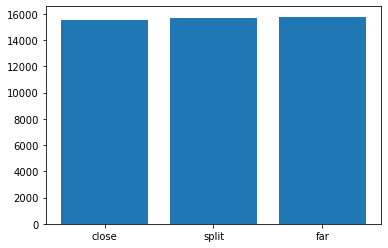

In [25]:
plt.bar(
    np.arange(3),
    height=[len(close_examples), len(split_examples), len(far_examples)],
    tick_label = ['close','split','far']
)

### Number of words used for description

In [26]:
def count_words(examples):
    description_words = dict()
    description_words_sorted = dict()
    tokenizer = BaselineTokenizer()

    for example in examples:
        words = tokenizer.encode(example.contents) # use content tokenizer
        description_length = len(words) - 2 # don't count start and end symbols

        if description_length in description_words.keys():
            description_words[description_length] += 1
        else:
            description_words[description_length] = 1

    for key in sorted(description_words):
        description_words_sorted[key] = description_words[key]

    assert np.sum(list(description_words_sorted.values())) == len(examples)
    
    return description_words_sorted

In [27]:
description_words = count_words(examples)

In [28]:
print(description_words)

{1: 19160, 2: 12195, 3: 4055, 4: 2872, 5: 2175, 6: 1697, 7: 1218, 8: 882, 9: 681, 10: 495, 11: 404, 12: 307, 13: 241, 14: 214, 15: 86, 16: 52, 17: 47, 18: 35, 19: 31, 20: 36, 21: 27, 22: 17, 23: 13, 24: 5, 25: 12, 26: 3, 27: 5, 28: 5, 29: 2, 30: 1, 31: 1, 32: 4, 33: 5, 34: 1, 35: 3, 36: 2, 37: 1, 39: 1, 41: 1, 44: 1, 53: 1}


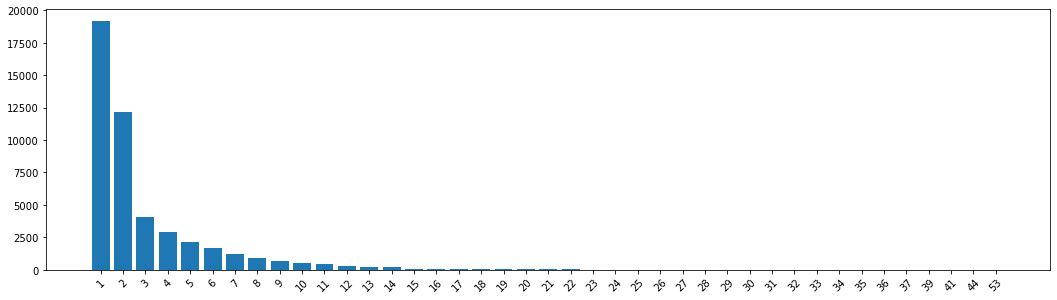

In [29]:
plt.figure(figsize=(18, 4.8))
plt.bar(
    np.arange(len(list(description_words.keys()))),
    height=list(description_words.values()),
    tick_label=list(description_words.keys())
)
plt.xticks(rotation=45)
plt.show()

### Bake-Off Corpus

The following code analyses the bake-off dataset. We will look at the number of examples for each of the conditions as well as the word count used to described the colors.

In [30]:
BAKE_OFF_COLORS_SRC_FILENAME = os.path.join(
    "data", "colors", "cs224u-colors-bakeoff-data.csv"
)

In [31]:
bake_off_corpus = ColorsCorpusReader(
    BAKE_OFF_COLORS_SRC_FILENAME,
    word_count=None,
    normalize_colors=True
)

In [32]:
bake_off_examples = list(bake_off_corpus.read())

In [33]:
len(bake_off_examples)

2031

In [34]:
bake_off_close_examples = [
    example for example in bake_off_examples if example.condition == "close"
]
bake_off_split_examples = [
    example for example in bake_off_examples if example.condition == "split"
]
bake_off_far_examples = [
    example for example in bake_off_examples if example.condition == "far"
]

In [35]:
print(f"close: {len(bake_off_close_examples)}")
print(f"split: {len(bake_off_split_examples)}")
print(f"far: {len(bake_off_far_examples)}")

close: 633
split: 652
far: 746


<BarContainer object of 3 artists>

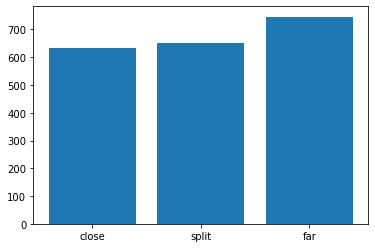

In [36]:
plt.bar(
    np.arange(3),
    height=[
        len(bake_off_close_examples),
        len(bake_off_split_examples),
        len(bake_off_far_examples)
    ],
    tick_label = ['close','split','far']
)

In [37]:
bake_off_description_words = count_words(bake_off_examples)

In [38]:
bake_off_description_words

{1: 817, 2: 1109, 3: 84, 4: 11, 5: 2, 6: 2, 7: 3, 8: 1, 11: 1, 12: 1}

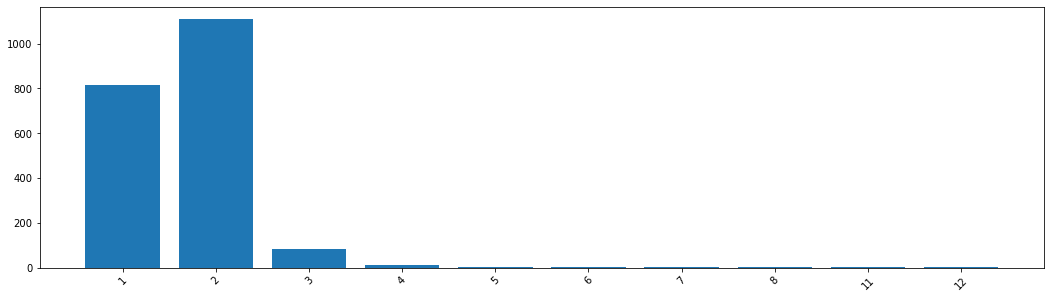

In [39]:
plt.figure(figsize=(18, 4.8))
plt.bar(
    np.arange(len(list(bake_off_description_words.keys()))),
    height=list(bake_off_description_words.values()),
    tick_label=list(bake_off_description_words.keys())
)
plt.xticks(rotation=45)
plt.show()

## Baseline-System

This baseline system is based on assignment 4.

In [40]:
tokenizer = BaselineTokenizer()
color_encoder = BaselineColorEncoder()
embedding = BaselineEmbedding()

### Baseline system development - dev dataset

The tiny dataset is used for baseline model development and fast testing.

In [41]:
def create_dev_data():
    dev_color_seqs, dev_word_seqs, dev_vocab = create_example_dataset(
        group_size=50,
        vec_dim=2
    )

    dev_colors_train, dev_colors_test, dev_words_train, dev_words_test = \
        train_test_split(dev_color_seqs, dev_word_seqs)
    
    return dev_vocab, dev_colors_train, dev_words_train, dev_colors_test, dev_words_test

In [42]:
dev_vocab, dev_colors_train, dev_tokens_train, dev_colors_test, dev_texts_test = \
    create_dev_data()

In [43]:
dev_glove_embedding, dev_glove_vocab = embedding.create_glove_embedding(dev_vocab)

In [44]:
dev_baseline_model = BaselineDescriber(
    dev_glove_vocab,
    embedding=dev_glove_embedding,
    early_stopping=True
)

In [45]:
%time _ = dev_baseline_model.fit(dev_colors_train, dev_tokens_train)

Stopping after epoch 12. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 1.480361819267273

CPU times: user 607 ms, sys: 55.7 ms, total: 663 ms
Wall time: 747 ms


In [46]:
dev_baseline_model.evaluate(dev_colors_test, dev_texts_test)

{'listener_accuracy': 0.4473684210526316, 'corpus_bleu': 0.05000000000000001}

### Model training - full dataset

The full color context dataset is used for final baseline model training.

In [47]:
def create_data():    
    rawcols, texts = zip(*[[ex.colors, ex.contents] for ex in examples])

    raw_colors_train, raw_colors_test, texts_train, texts_test = \
        train_test_split(rawcols, texts)

    tokens_train = [tokenizer.encode(text) for text in texts_train]
    colors_train = [
        color_encoder.encode_color_context(colors) for colors in raw_colors_train
    ]

    vocab = sorted({word for tokens in tokens_train for word in tokens})
    vocab += [UNK_SYMBOL]

    return vocab, colors_train, tokens_train, raw_colors_test, texts_test

In [48]:
vocab, colors_train, tokens_train, raw_colors_test, texts_test = create_data()

In [49]:
glove_embedding, glove_vocab = embedding.create_glove_embedding(vocab)

In [50]:
baseline_model = BaselineDescriber(
    glove_vocab,
    embedding=glove_embedding,
    early_stopping=True
)

In [ ]:
%time _ = baseline_model.fit(colors_train, tokens_train)

In [ ]:
def evaluate(trained_model, color_seqs_test, texts_test):
    tok_seqs = [tokenizer.encode(text) for text in texts_test]
    col_seqs = [color_encoder.encode_color_context(colors) for colors in color_seqs_test]

    return trained_model.evaluate(col_seqs, tok_seqs)

In [ ]:
evaluate(baseline_model, raw_colors_test, texts_test)

## Experiments

### BERT - Token Embeddings

Uses BERT token embedding. The tokens were created using BERT tokenizer. The embeddings were created using the nlu library.

In [51]:
from experiment.helper import Embedding, EmbeddingType

token_bert = Embedding(EmbeddingType.BERT_TOKENS)
bert_token_embeddings = token_bert.get_embeddings()

for index, word in enumerate(bert_token_embeddings.keys()):
    if index == 1:
        break
    print(f"{index}: {word} \n {bert_token_embeddings[word]}")

0: 1 
 [-6.38427794e-01 -2.01340929e-01 -3.03408146e-01 -5.64259529e-01
 -1.20634638e-01 -2.48514056e-01  1.12583593e-01 -6.26233071e-02
  2.34618008e-01 -7.53728569e-01 -3.71900469e-01 -3.23626161e-01
  3.15438926e-01 -1.61926657e-01  4.69628870e-02  4.44134921e-01
 -2.06054207e-02  2.00471729e-01  3.52511972e-01  7.54071057e-01
  2.52103031e-01  2.83721000e-01 -6.28947794e-01  1.87162310e-01
  1.59362093e-01  7.16134608e-01 -1.88292116e-01 -2.85534590e-01
 -3.00664902e-01  1.07732832e+00  6.27519548e-01 -7.54074216e-01
  8.73289287e-01  6.17699146e-01 -1.81464091e-01  2.84518898e-01
  3.27771246e-01 -6.50475174e-03 -3.55128795e-02 -2.71295220e-01
  3.80701303e-01 -2.64663517e-01  3.24273482e-02 -8.36178720e-01
  5.25373578e-01  8.18388402e-01 -2.87781894e-01 -3.42957303e-02
 -9.61877823e-01 -1.82180300e-01 -5.85041404e-01 -2.97508538e-01
 -2.47224152e-01  3.20151895e-01  4.21531737e-01 -8.78680587e-01
  3.02537024e-01  1.86673820e-01 -5.36366463e-01 -3.38853896e-01
  1.03464258e+00 -

In [52]:
from transformers import BertTokenizer

def tokenize(texts):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    tokens = []
    
    for text in texts:
        inputs = tokenizer(text)
        text_tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'])
        tokens.append(text_tokens)
        
    return tokens

In [53]:
def create_bert_token_data():
    rawcols, texts = zip(*[[ex.colors, ex.contents] for ex in examples])
    
    all_tokens = tokenize(texts)
    vocab_tokens = [item for sublist in all_tokens for item in sublist]
    vocab = set(vocab_tokens)

    raw_colors_train, raw_colors_test, texts_train, texts_test = \
        train_test_split(rawcols, texts)

    colors_train = [
        color_encoder.encode_color_context(colors) for colors in raw_colors_train
    ]
    
    colors_test = [
        color_encoder.encode_color_context(colors) for colors in raw_colors_test
    ]

    tokens_train = tokenize(texts_train)
    tokens_test = tokenize(texts_test)
    
    return list(vocab), colors_train, colors_test, tokens_train, tokens_test

In [54]:
vocab, colors_train, colors_test, tokens_train, tokens_test = create_bert_token_data()

In [57]:
bert_token_embeddings, vocab = bert.get_vocabulary_embeddings(vocabulary=vocab)

In [58]:
token_bert_model = BaselineDescriber(
    vocab,
    embedding=bert_token_embeddings,
    early_stopping=True
)

In [ ]:
%time _ = token_bert_model.fit(colors_train, tokens_train)

In [ ]:
token_bert_model.evaluate(colors_test, tokens_test)

### BERT - Embeddings

Uses embeddings from the BERT model which were created using baseline tokenizer (whole words) and the nlu library.

In [59]:
from experiment.helper import Embedding, EmbeddingType

bert = Embedding(EmbeddingType.BERT)
bert_embeddings = bert.get_embeddings()

for index, word in enumerate(bert_embeddings.keys()):
    if index == 1:
        break
    print(f"{index}: {word} \n {bert_embeddings[word]}")

0: 1 
 [-6.38427794e-01 -2.01340929e-01 -3.03408146e-01 -5.64259529e-01
 -1.20634638e-01 -2.48514056e-01  1.12583593e-01 -6.26233071e-02
  2.34618008e-01 -7.53728569e-01 -3.71900469e-01 -3.23626161e-01
  3.15438926e-01 -1.61926657e-01  4.69628870e-02  4.44134921e-01
 -2.06054207e-02  2.00471729e-01  3.52511972e-01  7.54071057e-01
  2.52103031e-01  2.83721000e-01 -6.28947794e-01  1.87162310e-01
  1.59362093e-01  7.16134608e-01 -1.88292116e-01 -2.85534590e-01
 -3.00664902e-01  1.07732832e+00  6.27519548e-01 -7.54074216e-01
  8.73289287e-01  6.17699146e-01 -1.81464091e-01  2.84518898e-01
  3.27771246e-01 -6.50475174e-03 -3.55128795e-02 -2.71295220e-01
  3.80701303e-01 -2.64663517e-01  3.24273482e-02 -8.36178720e-01
  5.25373578e-01  8.18388402e-01 -2.87781894e-01 -3.42957303e-02
 -9.61877823e-01 -1.82180300e-01 -5.85041404e-01 -2.97508538e-01
 -2.47224152e-01  3.20151895e-01  4.21531737e-01 -8.78680587e-01
  3.02537024e-01  1.86673820e-01 -5.36366463e-01 -3.38853896e-01
  1.03464258e+00 -

In [63]:
def tokenize(texts):
    tokenizer = BaselineTokenizer()
    tokens = []
    
    for text in texts:
        text_tokens = tokenizer.encode(text)
        tokens.append(text_tokens)
        
    return tokens

In [64]:
def create_bert_data():
    rawcols, texts = zip(*[[ex.colors, ex.contents] for ex in examples])
    
    all_tokens = tokenize(texts)
    vocab_tokens = [item for sublist in all_tokens for item in sublist]
    vocab = set(vocab_tokens)

    raw_colors_train, raw_colors_test, texts_train, texts_test = \
        train_test_split(rawcols, texts)

    colors_train = [
        color_encoder.encode_color_context(colors) for colors in raw_colors_train
    ]
    
    colors_test = [
        color_encoder.encode_color_context(colors) for colors in raw_colors_test
    ]

    tokens_train = tokenize(texts_train)
    tokens_test = tokenize(texts_test)
    
    return list(vocab), colors_train, colors_test, tokens_train, tokens_test

In [65]:
vocab, colors_train, colors_test, tokens_train, tokens_test = create_bert_data()

In [66]:
bert_vocab_embeddings, vocab = bert.get_vocabulary_embeddings(vocabulary=vocab)

In [67]:
bert_model = BaselineDescriber(
    vocab,
    embedding=bert_vocab_embeddings,
    early_stopping=True
)

In [68]:
%time _ = token_bert_model.fit(colors_train, tokens_train)

/Users/jh/ai/courses/stanford/2-NLU/final_project/3-xcs224u_final_paper/code/utils/torch_color_describer.py:680: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Stopping after epoch 64. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 111.90580177307129

CPU times: user 3h 22min 16s, sys: 1h 10min 21s, total: 4h 32min 37s
Wall time: 1h 54min 38s


In [69]:
token_bert_model.evaluate(colors_test, tokens_test)

{'listener_accuracy': 0.804323772235935, 'corpus_bleu': 0.5055816143244241}

### GPT-3: Few-Shot-Learning

This section compares the GPT-3 performance with the baseline system as well as the transformer section. GPT-3 uses system conditioning with zero-shot or few-short learning.

In [ ]:
# some more experiment with GPT-3 maybe to compare with few-shot-learning

# conditioning sequence:
#I am a highly intelligent question answering bot that can describe colors with human readable text as precisely as possible. Given an array of three context colors with their RGB (red, green, blue) values, describe the target color in such a way that a human could recognize the target color even if the colors were reordered. The target color is the last color in the array.

for example in (split_examples + close_examples)[:10]:
    print(f"\nQ: Describe the target color of {example.rgb_colors()}.")
    print(f"A: {example.contents}.")
    example.display(print_contents=False)